# 2. Bayesian Logistic Regression (LR)

Implementing the target distribution for a Bayesian logistic regression model fit to the German credit dataset. The predictors are normalized to zero mean and unit variance, and a weak zero-mean normal prior ($\sigma^2 = 100$) is placed on the intercept ($\alpha$) and the 24 regression coefficients ($\beta$).

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bml.samplers import nuts, hmc
from bml.distributions.lr import LogisticRegression
from bml.distributions.counter import GradCounter
from bml import metrics

In [10]:
# Fetch the German Credit (numeric) dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"
data = pd.read_csv(url, sep=r'\s+', header=None)

In [11]:
# Extract features (X) and response (y)
X_raw = data.iloc[:, :-1].values
y_raw = data.iloc[:, -1].values

# Map y from {1, 2} to {1, -1}
y = np.where(y_raw == 1, 1, -1)

# Normalize X to zero mean and unit variance
X_norm = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)

# Prepend a column of ones for the intercept alpha
X = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])
d = X.shape[1]  # Dimension is 25 (1 intercept + 24 predictors)

In [ ]:
theta0 = np.zeros(d) # Zero-mean starting point
M = 2000             # Total iterations
M_adapt = 1000       # Warmup/adaptation iterations
delta = 0.65         # Target acceptance rate
sigma_sq = 100.0

results = {}
lr = LogisticRegression(X, y, sigma_sq)

for sampler_name, SamplerClass in [("Dual Averaging NUTS", nuts.DualAveragingNUTS), 
                                   ("Dual Averaging HMC", hmc.DualAveragingHMC)]:
    print(f"Starting {sampler_name} sampling for Bayesian LR...")
    
    sampler = SamplerClass(L=lr.log_p, grad=lr.grad_log_p)
    
    if sampler_name == "Dual Averaging HMC":
        # Shortest optimal lambda for HLR is ~0.14 based on paper's findings
        samples, stats = sampler.sample(theta0, delta=delta, lam=0.14, M=M, M_adapt=M_adapt)
    else:
        samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
        
    print(f"Finished sampling with {sampler_name}. Output shape: {samples.shape}")
    
    valid_samples = samples[M_adapt:]
    
    # Calculate ESS manually across all 25 dimensions
    sample_means = np.mean(valid_samples, axis=0)
    sample_vars = np.var(valid_samples, axis=0)
    
    min_ess = float('inf')
    for dim in range(d):
        dim_samples = valid_samples[:, dim]
        mu = sample_means[dim]
        var = sample_vars[dim]
        
        ess_mean = metrics.compute_ess_1d(dim_samples, mu, var)
        
        moment_samples = (dim_samples - mu)**2
        moment_mu = np.mean(moment_samples)
        moment_var = np.var(moment_samples)
        ess_variance = metrics.compute_ess_1d(moment_samples, moment_mu, moment_var)
        
        min_ess = min(min_ess, ess_mean, ess_variance)
        
    results[sampler_name] = min_ess
    print(f"Worst-case ESS across all dimensions for {sampler_name}: {min_ess:.4f}\n")

Starting Dual Averaging NUTS sampling for Bayesian LR...
Finished sampling with Dual Averaging NUTS. Output shape: (2001, 25)
Worst-case ESS across all dimensions for Dual Averaging NUTS: 280.1399

Starting Dual Averaging HMC sampling for Bayesian LR...
Finished sampling with Dual Averaging HMC. Output shape: (2001, 25)
Worst-case ESS across all dimensions for Dual Averaging HMC: 102.0438



In [ ]:
deltas = np.linspace(0.25, 0.95, 15)
results_delta = []

for delta in deltas:
    print(f"Sampling for Delta={delta:.2f}...")

    model = GradCounter(lr)
    sampler = nuts.DualAveragingNUTS(L=model.log_p, grad=model.grad)

    theta0 = np.zeros(d)
    samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
    
    valid_samples = samples[M_adapt:]
    
    # Calculate ESS manually across all dimensions
    sample_means = np.mean(valid_samples, axis=0)
    sample_vars = np.var(valid_samples, axis=0)
    
    min_ess = float('inf')
    for dim in range(d):
        dim_samples = valid_samples[:, dim]
        mu = sample_means[dim]
        var = sample_vars[dim]
        
        ess_mean = metrics.compute_ess_1d(dim_samples, mu, var)
        
        # ESS for the second central moment
        moment_samples = (dim_samples - mu)**2
        moment_mu = np.mean(moment_samples)
        moment_var = np.var(moment_samples)
        ess_variance = metrics.compute_ess_1d(moment_samples, moment_mu, moment_var)
        
        # Worst-case between mean and variance ESS for this dimension
        min_ess = min(min_ess, ess_mean, ess_variance)

    total_gradients = model.count
    ess_per_gradient = min_ess / total_gradients
    results_delta.append((delta, min_ess, total_gradients, ess_per_gradient))
    print(f"Delta: {delta:.2f}, Worst-case ESS: {min_ess:.4f}, Total Gradients: {total_gradients}, ESS/Gradient: {ess_per_gradient:.6f}\n")

results_df = pd.DataFrame(results_delta, columns=["Delta", "Worst-case ESS", "Total Gradients", "ESS per Gradient"])
results_df.to_csv("../results/LR/DANUTS_delta.csv", index=False)

Sampling for Delta=0.25...
Delta: 0.25, Worst-case ESS: 86.9384, Total Gradients: 16950, ESS/Gradient: 0.005129

Sampling for Delta=0.30...
Delta: 0.30, Worst-case ESS: 188.0457, Total Gradients: 19106, ESS/Gradient: 0.009842

Sampling for Delta=0.35...
Delta: 0.35, Worst-case ESS: 176.9373, Total Gradients: 19882, ESS/Gradient: 0.008899

Sampling for Delta=0.40...
Delta: 0.40, Worst-case ESS: 265.3447, Total Gradients: 21286, ESS/Gradient: 0.012466

Sampling for Delta=0.45...
Delta: 0.45, Worst-case ESS: 233.6519, Total Gradients: 22314, ESS/Gradient: 0.010471

Sampling for Delta=0.50...
Delta: 0.50, Worst-case ESS: 349.6032, Total Gradients: 24522, ESS/Gradient: 0.014257

Sampling for Delta=0.55...
Delta: 0.55, Worst-case ESS: 267.0349, Total Gradients: 25186, ESS/Gradient: 0.010603

Sampling for Delta=0.60...
Delta: 0.60, Worst-case ESS: 391.0364, Total Gradients: 26686, ESS/Gradient: 0.014653

Sampling for Delta=0.65...
Delta: 0.65, Worst-case ESS: 307.7404, Total Gradients: 28078,

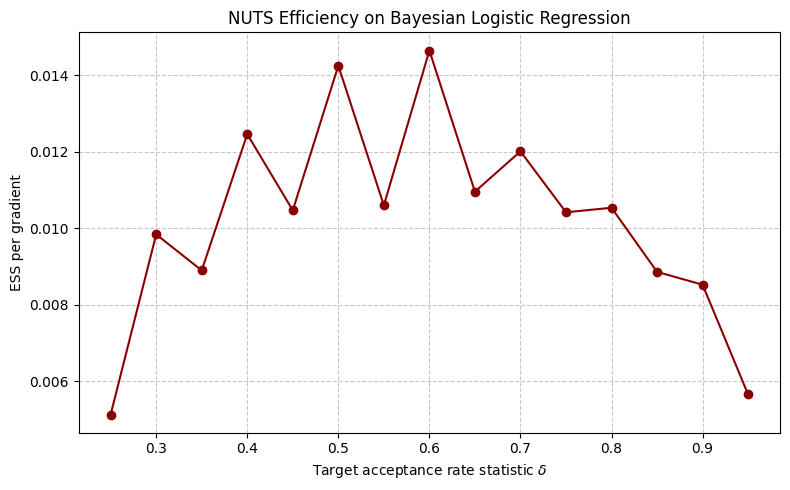

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Delta"], results_df["ESS per Gradient"], marker='o', linestyle='-', color='darkred')
plt.xlabel('Target acceptance rate statistic $\\delta$')
plt.ylabel('ESS per gradient')
plt.title('NUTS Efficiency on Bayesian Logistic Regression')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("../results/LR/LR_efficiency_plot.png")
plt.show()